In [1]:
import librosa
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pprint as pp

from scipy.stats import entropy
from scipy.stats import chisquare
from scipy.stats import kurtosis

In [2]:
#from music_production_and_performance.theory.western.scales.chromatic import chromatic_scale_pitch_class_names
chromatic_scale_pitch_class_names = ['C', 'Db', 'D', 'Eb', 'E', 'F', 'F#', 'G', 'Ab', 'A', 'Bb', 'B']

In [3]:
class Track():
    def __init__(
        self,
        track_to_analyze_filename : str,
        track_title : str,
        sampling_rate_for_import : int = 48000,
    ):
        self.track_to_analyze_filename = track_to_analyze_filename
        self.track_title = track_title
        self.sampling_rate_for_import = sampling_rate_for_import

In [4]:
class KeyDetection(Track):
    def __init__(
        self,
        track_to_analyze_filename : str,
        track_title : str,
        sampling_rate_for_import : int = 48000,
        hop_length : int = 1024
    ):
        super().__init__(track_to_analyze_filename, track_title, sampling_rate_for_import)
        self.hop_length = hop_length

        self.chromagram_method_list = []
        self.chromagram_method_name_list = []
        self.is_fit = False

    def fit(self):
        self.is_fit = True
        self.load_track_timeseries()
        self.separate_harmonics_and_percussives()
        self.compute_chromagrams()
        self.estimate_key()
        self.compute_uniformity_metrics()

        self.df = pd.merge(
            self.df_estimated_key,
            self.df_uniformity,
            on = ['track_title', 'track_to_analyze_filename', 'method'],
            how = 'left',
        )

    def summary_full(self):
        self.display_key_estimates()
        self.plot_split_harmonics_and_percussives()
        self.display_chromagrams()
        self.plot_chromagram_boxplot()
        pp.pprint(self.df_uniformity)

    def summary_key_detection(self):
        self.display_key_estimates()
        self.plot_chromagram_boxplot()
    
    def load_track_timeseries(self):
        #
        # we are using a single mono channel here for these analyses
        #
        self.y, self.sr = librosa.load(
            self.track_to_analyze_filename,
            sr = self.sampling_rate_for_import,
        )  

    def separate_harmonics_and_percussives(self):
        self.y_harmonic, self.y_percussive = librosa.effects.hpss(self.y)

    def plot_split_harmonics_and_percussives(self):
        plt.figure(figsize = [25, 8])

        plt.subplot(2, 1, 1)
        plt.plot(self.y_harmonic)
        plt.title('Harmonics Waveform')
        plt.tight_layout()

        plt.subplot(2, 1, 2)
        plt.plot(self.y_percussive)
        plt.title('Percussives Waveform')
        plt.tight_layout()

        plt.show()
        plt.close()

    # Normalized energy for each chroma bin at each frame.
    # https://librosa.org/doc/main/generated/librosa.feature.chroma_stft.html
    #
    # Energy distribution of each pitch class across time:
    # 
    def compute_chromagrams(self):
        self.chromagram_stft = librosa.feature.chroma_stft(
            y = self.y_harmonic,
            sr = self.sampling_rate_for_import,
            hop_length = self.hop_length,
        )
        self.chromagram_method_list.append(self.chromagram_stft)
        self.chromagram_method_name_list.append('Short-Time Fourier Transform')
        
        self.chromagram_cqt = librosa.feature.chroma_cqt(
            y = self.y_harmonic,
            sr = self.sampling_rate_for_import,
            hop_length = self.hop_length,
        ) 
        self.chromagram_method_list.append(self.chromagram_cqt)
        self.chromagram_method_name_list.append('Constant-Q Transform')

        #
        # boxplot content prep et. al.
        #
        self.chromagram_values_list_per_method_per_note = {}
        for chrm, method in zip(self.chromagram_method_list, self.chromagram_method_name_list):
            self.chromagram_values_list_per_method_per_note[method] = []
            for note_index in np.arange(0, chrm.shape[0]):
                self.chromagram_values_list_per_method_per_note[method].append(chrm[note_index, :])     
        
    # Energy distribution of each pitch class across time
    def display_chromagrams(self):
        for chrm, method in zip(self.chromagram_method_list, self.chromagram_method_name_list):
            fig, ax = plt.subplots(sharex=True, sharey=True, figsize = [12, 6])
            img = librosa.display.specshow(chrm, y_axis = 'chroma', x_axis = 'time', ax = ax)
            ax.set(title='Chromagram: "' + self.track_title + '"\nMethod: "' + method + '"')
            fig.colorbar(img, ax=ax)
            plt.tight_layout()
            plt.show()
            plt.close()

    def plot_chromagram_boxplot(self):
        #for chrm, method in zip(self.chromagram_method_list, self.chromagram_method_name_list):
            #per_note_chromagram_values_list = []
            #for note_index in np.arange(0, chrm.shape[0]):
            #    per_note_chromagram_values_list.append(chrm[note_index, :])

        for method in self.chromagram_values_list_per_method_per_note.keys():
            plt.figure()
            plt.boxplot(self.chromagram_values_list_per_method_per_note[method], widths=0.85, showmeans=True, meanline=True)
            plt.xticks(np.arange(1, len(chromatic_scale_pitch_class_names) + 1), chromatic_scale_pitch_class_names)
            plt.title('Energy Distribution of Each Pitch Class Across Time\nMethod = "' + method + '"')
            plt.tight_layout()
            plt.show()
            plt.close()

    def estimate_key(self):
        key_estimate_list = []
        for chrm, method in zip(self.chromagram_method_list, self.chromagram_method_name_list):
            key_estimate_dict = {
                'track_title' : self.track_title,
                'track_to_analyze_filename' : self.track_to_analyze_filename,
                'method' : method,
            }
            
            key_as_chromatic_index = np.argmax(np.mean(chrm, axis = 1))
            key_estimate_dict['key_as_chromatic_index'] = key_as_chromatic_index
            key_estimate_dict['key_as_pitch_class'] = chromatic_scale_pitch_class_names[key_as_chromatic_index]
            key_estimate_list.append(key_estimate_dict)
        self.df_estimated_key = pd.DataFrame(key_estimate_list)

    def display_key_estimates(self):
        pp.pprint(self.df_estimated_key.to_dict(orient = 'records'))

    def compute_uniformity_metrics(self):
        uniformity_metrics_list = []
        for chrm, method in zip(self.chromagram_method_list, self.chromagram_method_name_list):
            
            uniformity_metrics = {
                'track_title' : self.track_title,
                'track_to_analyze_filename' : self.track_to_analyze_filename,
                'method' : method,
            }
            
            #self.uniformity_metrics[method] = {}
            probability_distribution = np.mean(chrm, axis = 1) / np.sum(np.mean(chrm, axis = 1))
            N = len(probability_distribution)
            uniform_distribution = np.array([1. / N] * N)

            # dissimilarity indices
            uniformity_metrics['dissimilarity_index'] = 0.5 * np.sum(np.abs(probability_distribution - uniform_distribution))
            
            # Chi^2 goodness of fit test
            f_obs = np.round(probability_distribution * 10000)
            f_exp = [np.sum(f_obs) / N] * N
            chi2_statistic, p_value = chisquare(f_obs = f_obs, f_exp = f_exp)
            effect_size_cohens_w = np.sqrt(chi2_statistic / N)
            uniformity_metrics['chi2_goodness_of_fit_statistic'] = chi2_statistic
            uniformity_metrics['chi2_goodness_of_fit_p_value'] = p_value
            uniformity_metrics['chi2_goodness_of_fit_cohens_w'] = effect_size_cohens_w

            # kurtosis
            uniformity_metrics['kurtosis'] = kurtosis(probability_distribution)

            # entropy
            uniformity_metrics['entropy'] = entropy(probability_distribution)
            
            uniformity_metrics_list.append(uniformity_metrics)
        
        self.df_uniformity = pd.DataFrame(uniformity_metrics_list)


[{'key_as_chromatic_index': 0,
  'key_as_pitch_class': 'C',
  'method': 'Short-Time Fourier Transform',
  'track_title': 'Kwiky Bridge (Instant Satisfaction Mix)',
  'track_to_analyze_filename': '/home/emily/Downloads/Lady Napalm - Kwiky '
                               'Bridge (Instant Satisfaction Mix).aiff'},
 {'key_as_chromatic_index': 0,
  'key_as_pitch_class': 'C',
  'method': 'Constant-Q Transform',
  'track_title': 'Kwiky Bridge (Instant Satisfaction Mix)',
  'track_to_analyze_filename': '/home/emily/Downloads/Lady Napalm - Kwiky '
                               'Bridge (Instant Satisfaction Mix).aiff'}]


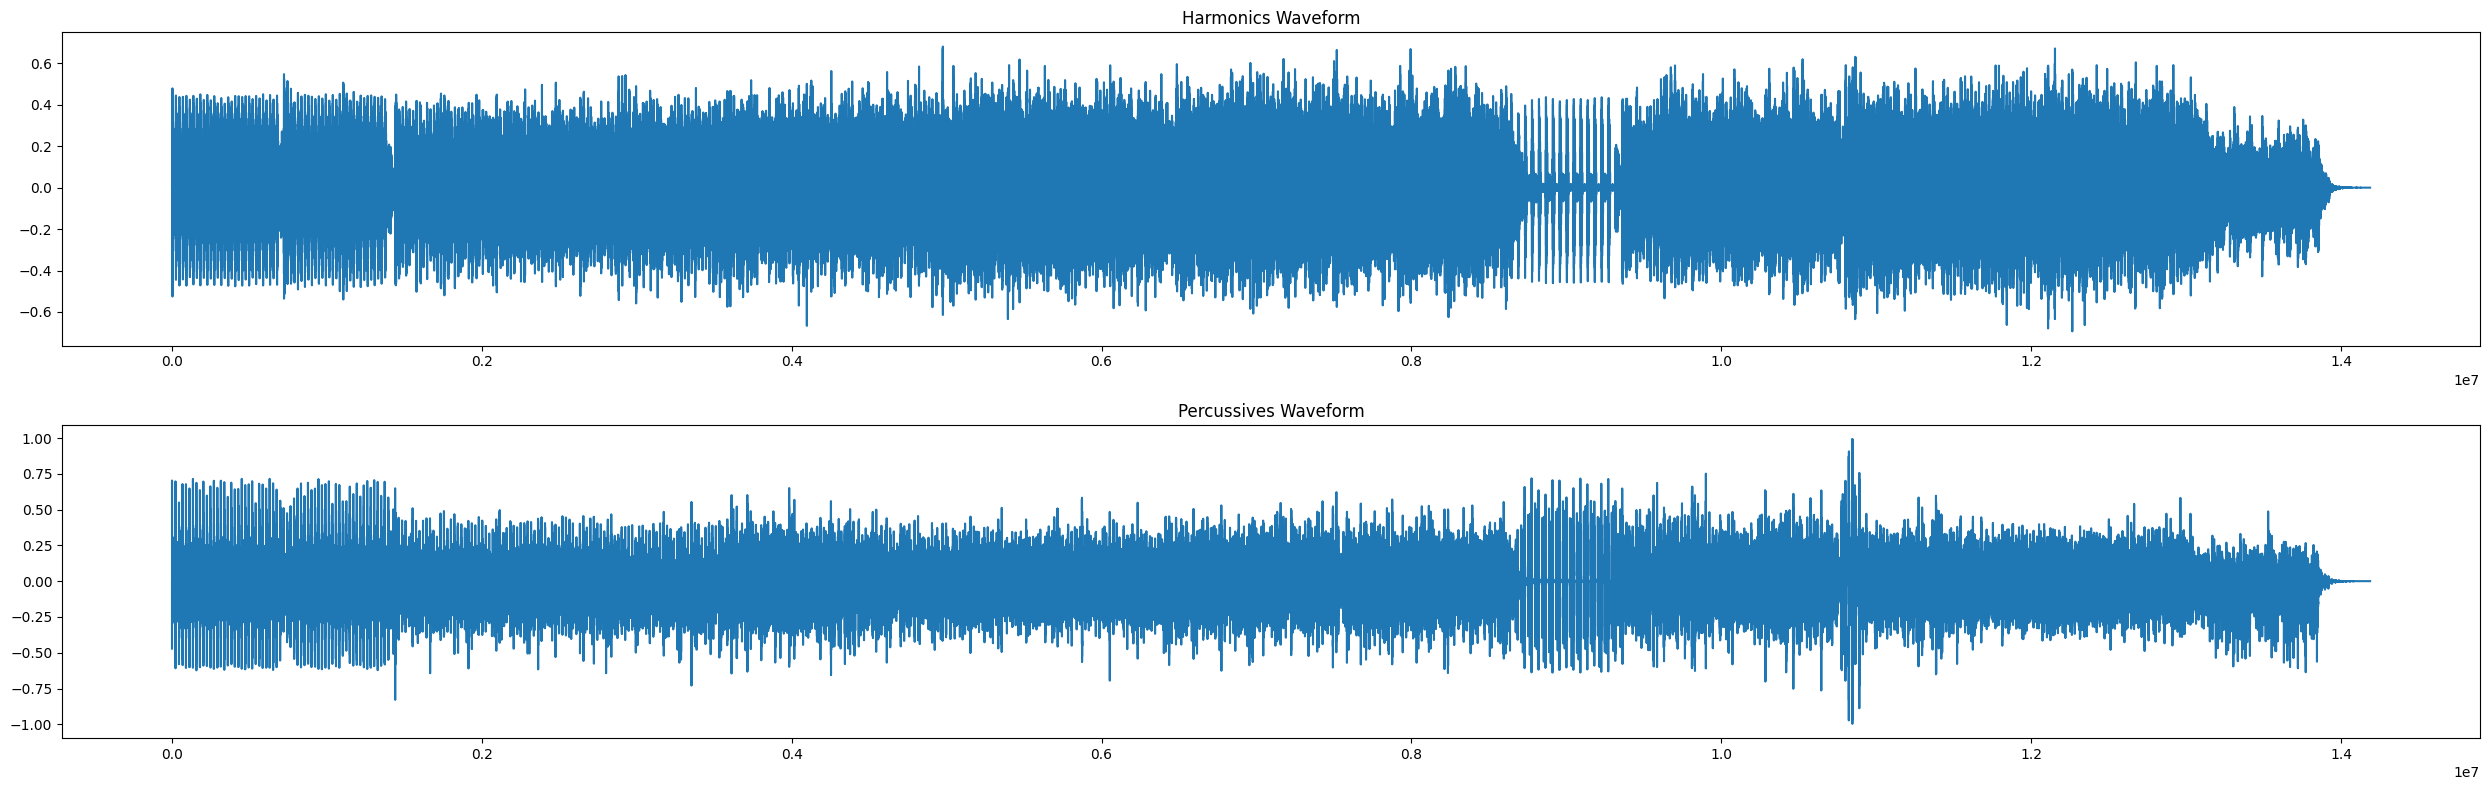

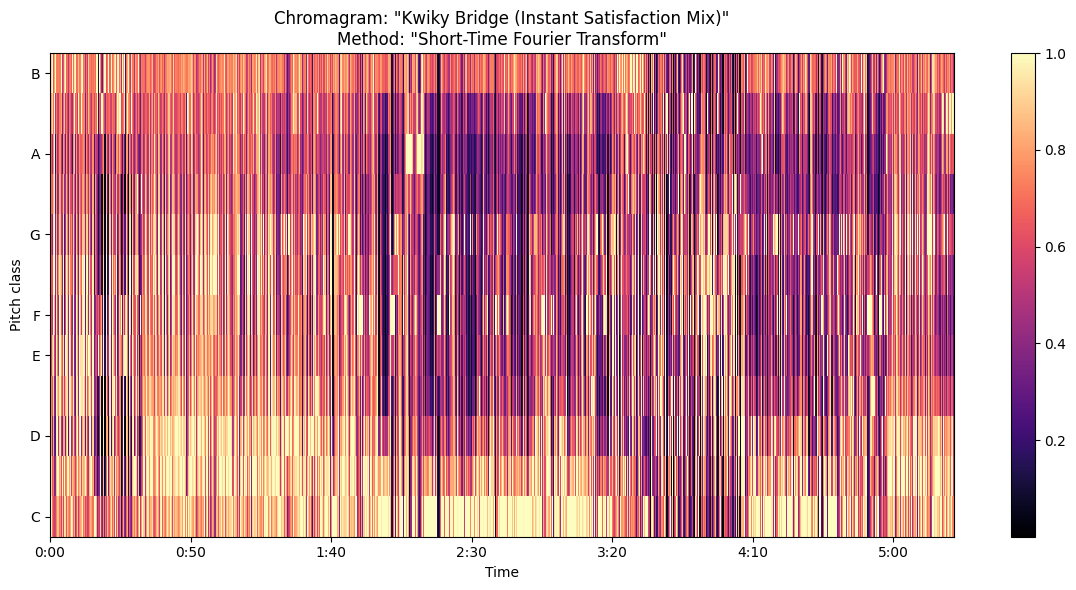

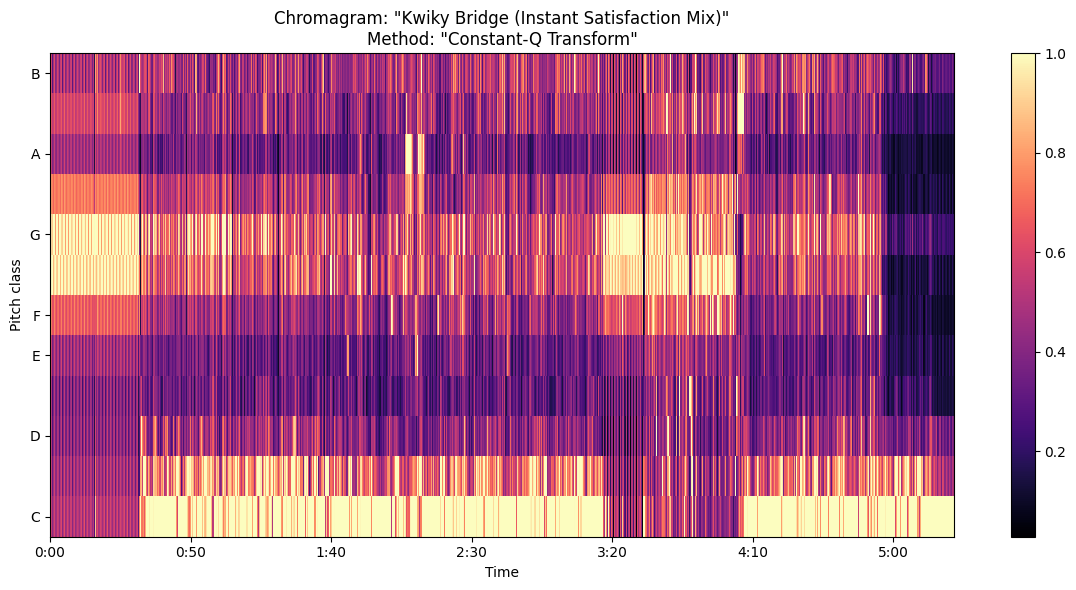

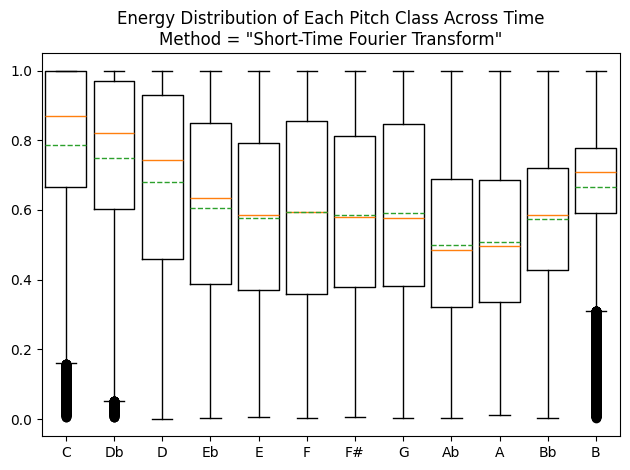

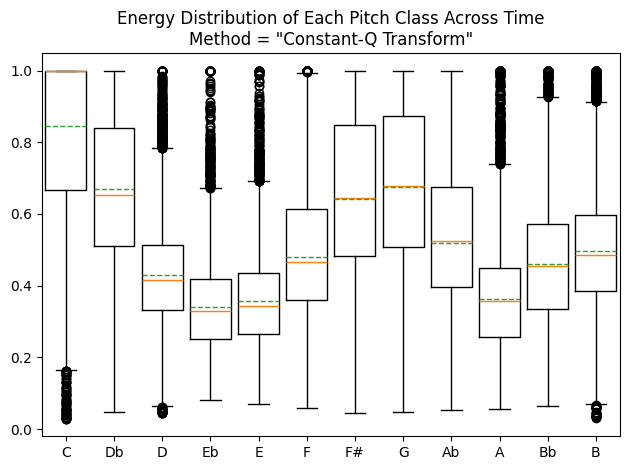

                               track_title  \
0  Kwiky Bridge (Instant Satisfaction Mix)   
1  Kwiky Bridge (Instant Satisfaction Mix)   

                           track_to_analyze_filename  \
0  /home/emily/Downloads/Lady Napalm - Kwiky Brid...   
1  /home/emily/Downloads/Lady Napalm - Kwiky Brid...   

                         method  dissimilarity_index  \
0  Short-Time Fourier Transform             0.054875   
1          Constant-Q Transform             0.117595   

   chi2_goodness_of_fit_statistic  chi2_goodness_of_fit_p_value  \
0                      181.146985                  5.942297e-33   
1                      804.106400                 2.487762e-165   

   chi2_goodness_of_fit_cohens_w  kurtosis   entropy  
0                       3.885303 -0.491163  2.476013  
1                       8.185894 -0.474514  2.446086  


In [5]:
track_to_analyze = '/home/emily/Downloads/Lady Napalm - Kwiky Bridge (Instant Satisfaction Mix).aiff'
track_name = 'Kwiky Bridge (Instant Satisfaction Mix)'
t_kb = KeyDetection(track_to_analyze, track_name)
t_kb.fit()
t_kb.summary_full()

In [6]:
t_kb.df

,track_title,track_to_analyze_filename,method,key_as_chromatic_index,key_as_pitch_class,dissimilarity_index,chi2_goodness_of_fit_statistic,chi2_goodness_of_fit_p_value,chi2_goodness_of_fit_cohens_w,kurtosis,entropy
0,Kwiky Bridge (Instant Satisfaction Mix),/home/emily/Downloads/Lady Napalm - Kwiky Brid...,Short-Time Fourier Transform,0,C,0.054875,181.146985,5.942297e-33,3.885303,-0.491163,2.476013
1,Kwiky Bridge (Instant Satisfaction Mix),/home/emily/Downloads/Lady Napalm - Kwiky Brid...,Constant-Q Transform,0,C,0.117595,804.106400,2.487762e-165,8.185894,-0.474514,2.446086


[{'key_as_chromatic_index': 6,
  'key_as_pitch_class': 'F#',
  'method': 'Short-Time Fourier Transform',
  'track_title': 'Voice in the Distance',
  'track_to_analyze_filename': '/home/emily/Downloads/Lady Napalm - Voice in '
                               'the Distance.aiff'},
 {'key_as_chromatic_index': 6,
  'key_as_pitch_class': 'F#',
  'method': 'Constant-Q Transform',
  'track_title': 'Voice in the Distance',
  'track_to_analyze_filename': '/home/emily/Downloads/Lady Napalm - Voice in '
                               'the Distance.aiff'}]


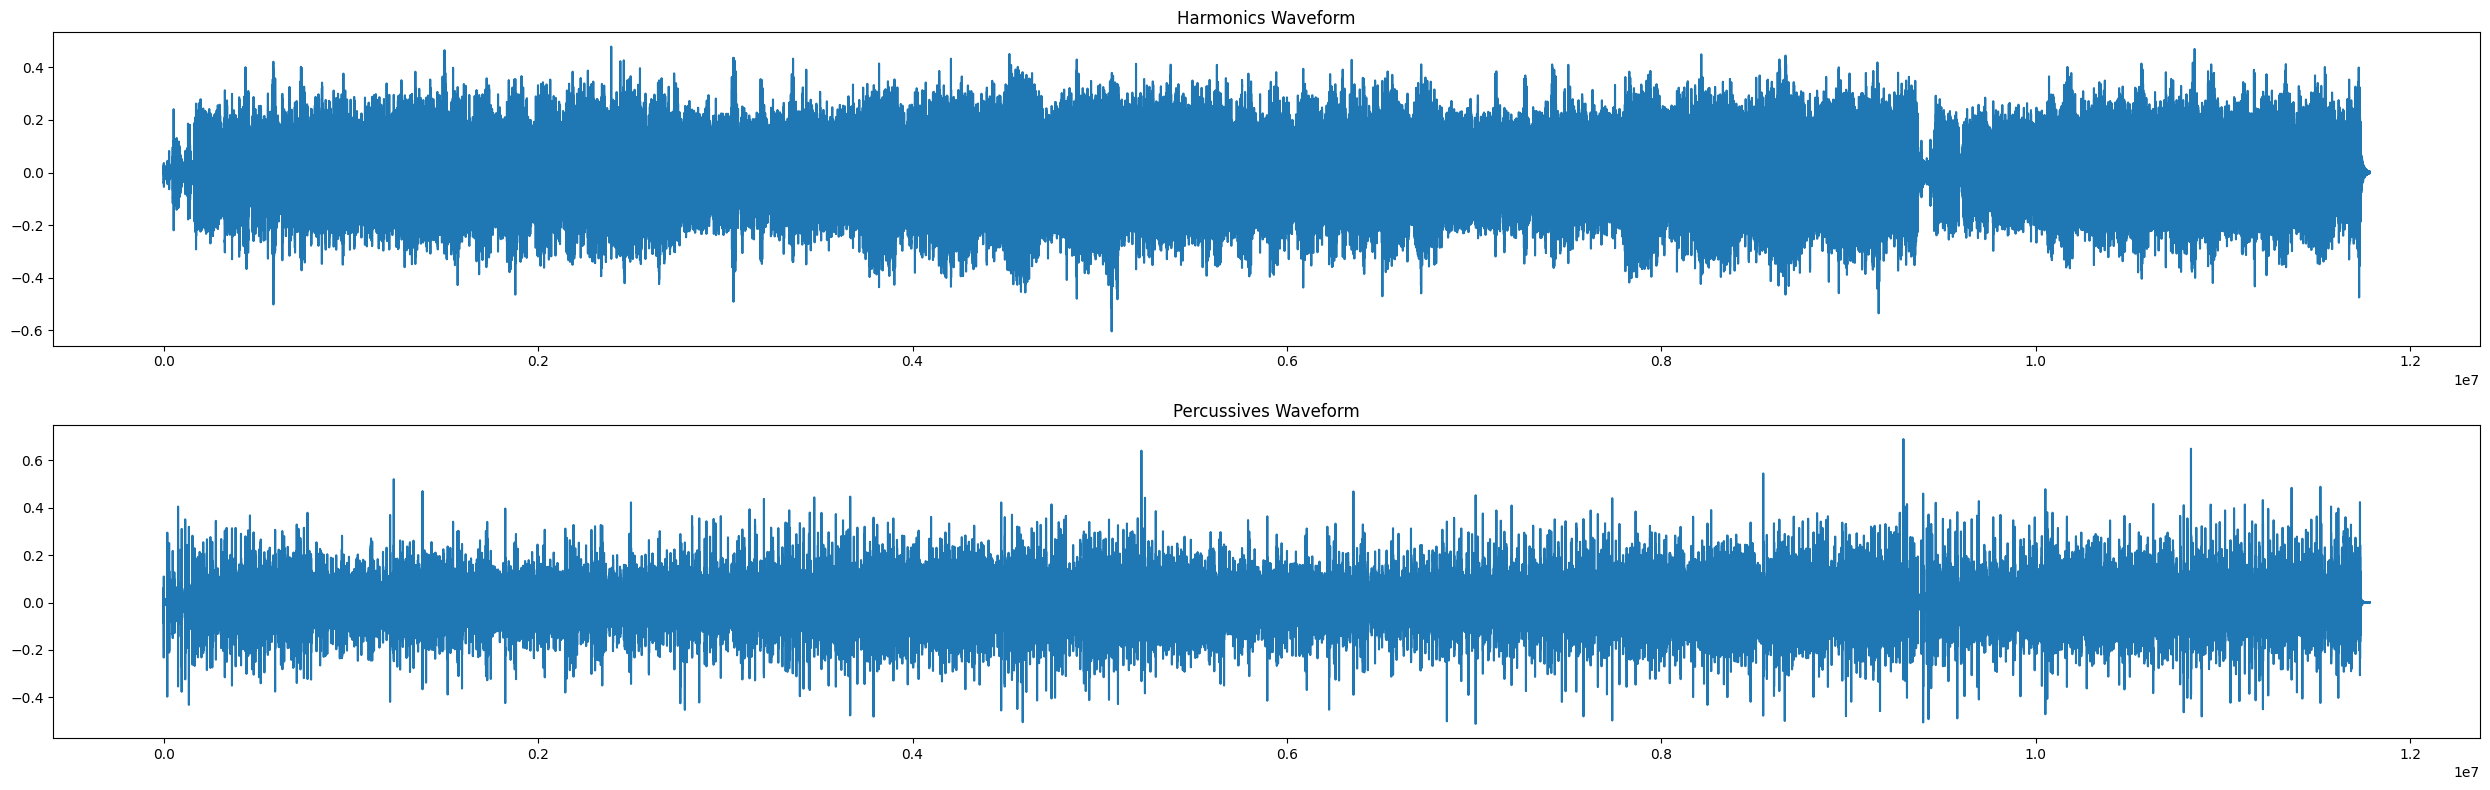

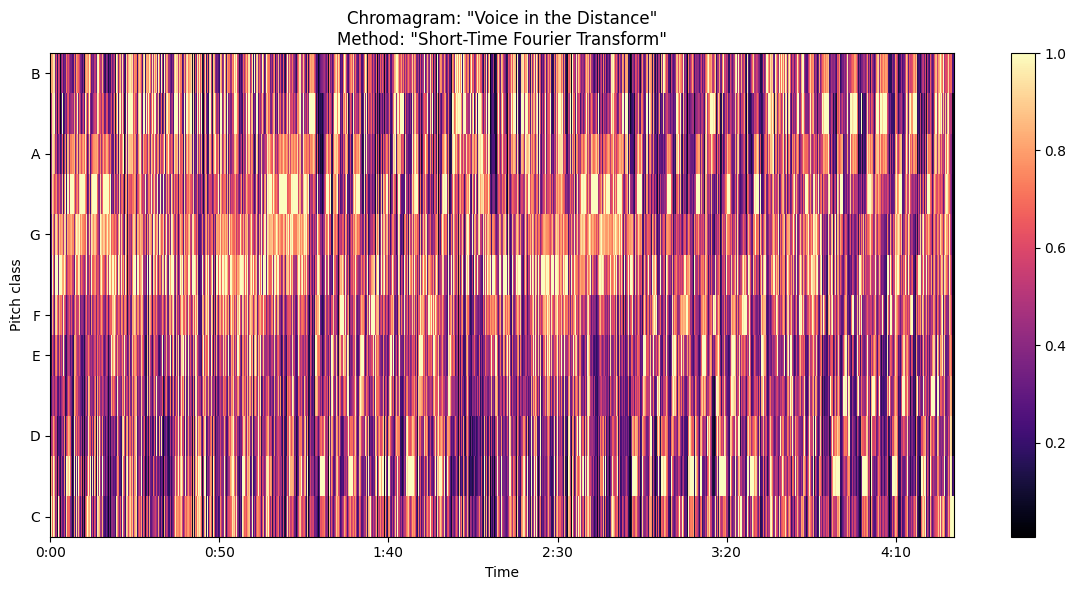

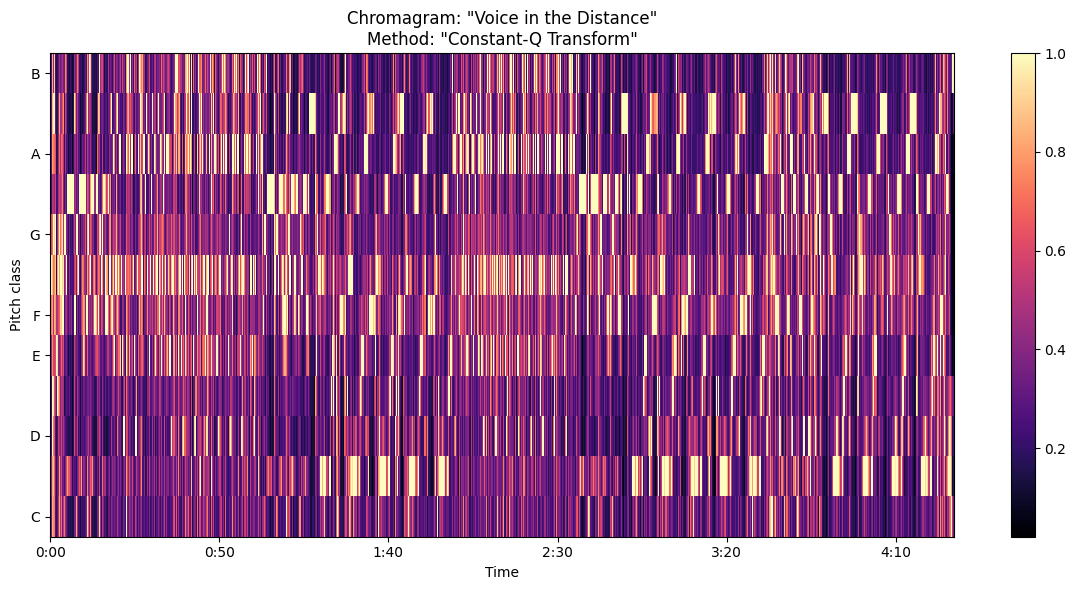

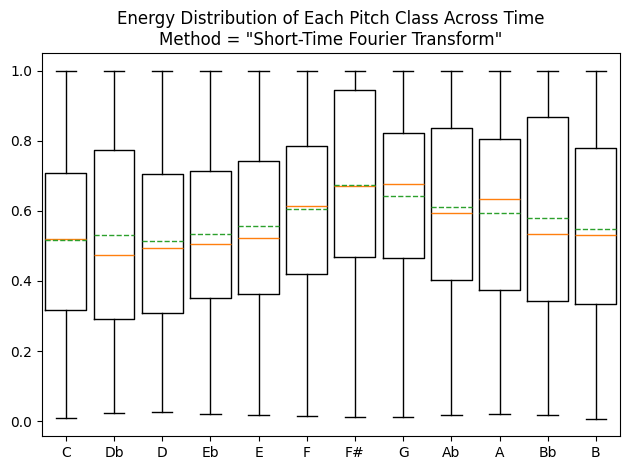

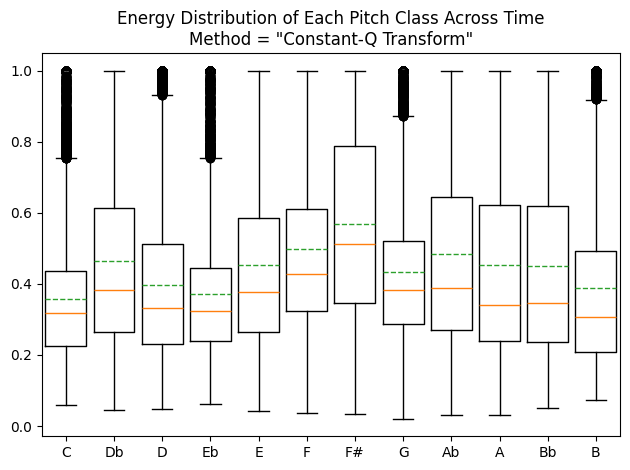

             track_title                          track_to_analyze_filename  \
0  Voice in the Distance  /home/emily/Downloads/Lady Napalm - Voice in t...   
1  Voice in the Distance  /home/emily/Downloads/Lady Napalm - Voice in t...   

                         method  dissimilarity_index  \
0  Short-Time Fourier Transform             0.036506   
1          Constant-Q Transform             0.050766   

   chi2_goodness_of_fit_statistic  chi2_goodness_of_fit_p_value  \
0                       71.903581                  5.302172e-11   
1                      163.981502                  2.037758e-29   

   chi2_goodness_of_fit_cohens_w  kurtosis   entropy  
0                       2.447849 -0.810689  2.481353  
1                       3.696637 -0.238692  2.476789  


In [7]:
track_to_analyze = '/home/emily/Downloads/Lady Napalm - Voice in the Distance.aiff'
track_name = 'Voice in the Distance'
t_vd = KeyDetection(track_to_analyze, track_name)
t_vd.fit()
t_vd.summary_full()

In [9]:
t_vd.df

,track_title,track_to_analyze_filename,method,key_as_chromatic_index,key_as_pitch_class,dissimilarity_index,chi2_goodness_of_fit_statistic,chi2_goodness_of_fit_p_value,chi2_goodness_of_fit_cohens_w,kurtosis,entropy
0,Voice in the Distance,/home/emily/Downloads/Lady Napalm - Voice in t...,Short-Time Fourier Transform,6,F#,0.036506,71.903581,5.302172e-11,2.447849,-0.810689,2.481353
1,Voice in the Distance,/home/emily/Downloads/Lady Napalm - Voice in t...,Constant-Q Transform,6,F#,0.050766,163.981502,2.037758e-29,3.696637,-0.238692,2.476789
